In [1]:
import torch
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from tempfile import TemporaryDirectory
import time
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Загрузка и нормализация данных

In [16]:
data_transforms = {
    'train': v2.Compose([
        v2.RandomCrop(32, padding=4),
        v2.RandomHorizontalFlip(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]),
    'val': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]),
    'test': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]),
}

phases = ['train', 'val', 'test']
datasets = {x: torchvision.datasets.CIFAR10(root='./data', train=x != 'test', download=True, transform=data_transforms[x]) for x in phases}

indices = list(range(len(datasets['train'])))
train_idx, val_idx = train_test_split(indices, random_state=42)

datasets['train'] = Subset(datasets['train'], train_idx)
datasets['val'] = Subset(datasets['val'], val_idx)

batch_size = 32

dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True) for x in phases}
dataset_sizes = {x: len(datasets[x]) for x in phases}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Давайте ради интереса покажем несколько изображений в тренировочных данных.

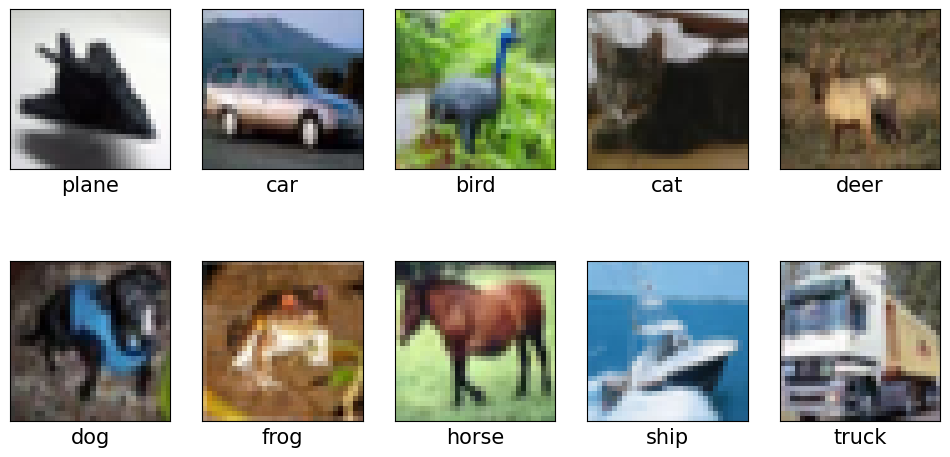

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
sample_images = [datasets['train'].dataset.data[np.asarray(datasets['train'].dataset.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## Определим сверточную нейронную сеть

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        
        self.bn_conv1 = nn.BatchNorm2d(16)
        self.bn_conv2 = nn.BatchNorm2d(16)
        self.bn_conv3 = nn.BatchNorm2d(32)
        self.bn_conv4 = nn.BatchNorm2d(32)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.bn_fc2 = nn.BatchNorm1d(32)

        self.pool = nn.MaxPool2d(2, 2)

        self.dropout_conv = nn.Dropout2d(0.25)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = F.relu(self.bn_conv1(self.conv1(x)))
        out = F.relu(self.bn_conv2(self.conv2(out)))
        out = self.pool(out)
        out = self.dropout_conv(out)

        out = F.relu(self.bn_conv3(self.conv3(out)))
        out = F.relu(self.bn_conv4(self.conv4(out)))
        out = self.pool(out)
        out = self.dropout_conv(out)

        out = torch.flatten(out, 1)  # flatten all dimensions except batch

        out = F.relu(self.bn_fc1(self.fc1(out)))
        out = self.dropout(out)

        out = F.relu(self.bn_fc2(self.fc2(out)))
        out = self.dropout(out)

        out = self.fc3(out)
        return out


net = Net().to(device)

In [10]:
total_params = sum(p.numel() for p in net.parameters())
print(f'Number of parameters: {total_params}')

Number of parameters: 283898


## Определим функцию потерь и алгоритм оптимизации

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=0)

# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Обучим нейронную сеть

In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        loss_hist, acc_hist = {x: [] for x in ['train', 'val']}, {x: [] for x in ['train', 'val']}
        # loss_hist_val, acc_hist_val = [], []

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.shape[0]
                    running_corrects += torch.sum(preds == labels.data).item()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]

                if phase == 'val':
                    scheduler.step(epoch_loss)

                print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')

                loss_hist[phase].append(epoch_loss)
                acc_hist[phase].append(epoch_acc)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, loss_hist, acc_hist

In [14]:
net, loss_hist, acc_hist = train_model(net, criterion, optimizer, scheduler, num_epochs=100)

Epoch 1/100
----------
train Loss: 1.9781 Accuracy: 0.2480
val Loss: 1.6826 Accuracy: 0.3859

Epoch 2/100
----------
train Loss: 1.8245 Accuracy: 0.3121
val Loss: 1.5830 Accuracy: 0.4086

Epoch 3/100
----------
train Loss: 1.7539 Accuracy: 0.3448
val Loss: 1.4773 Accuracy: 0.4593

Epoch 4/100
----------
train Loss: 1.7087 Accuracy: 0.3625
val Loss: 1.4143 Accuracy: 0.4786

Epoch 5/100
----------
train Loss: 1.6847 Accuracy: 0.3761
val Loss: 1.3835 Accuracy: 0.4894

Epoch 6/100
----------
train Loss: 1.6479 Accuracy: 0.3904
val Loss: 1.3299 Accuracy: 0.5159

Epoch 7/100
----------
train Loss: 1.6302 Accuracy: 0.3999
val Loss: 1.3038 Accuracy: 0.5241

Epoch 8/100
----------
train Loss: 1.6067 Accuracy: 0.4119
val Loss: 1.2554 Accuracy: 0.5390

Epoch 9/100
----------
train Loss: 1.5935 Accuracy: 0.4183
val Loss: 1.2319 Accuracy: 0.5562

Epoch 10/100
----------
train Loss: 1.5610 Accuracy: 0.4302
val Loss: 1.2008 Accuracy: 0.5621

Epoch 11/100
----------
train Loss: 1.5540 Accuracy: 0.4310

In [53]:
PATH = "./data"
torch.save(net.state_dict(), os.path.join(PATH, "net.pt"))

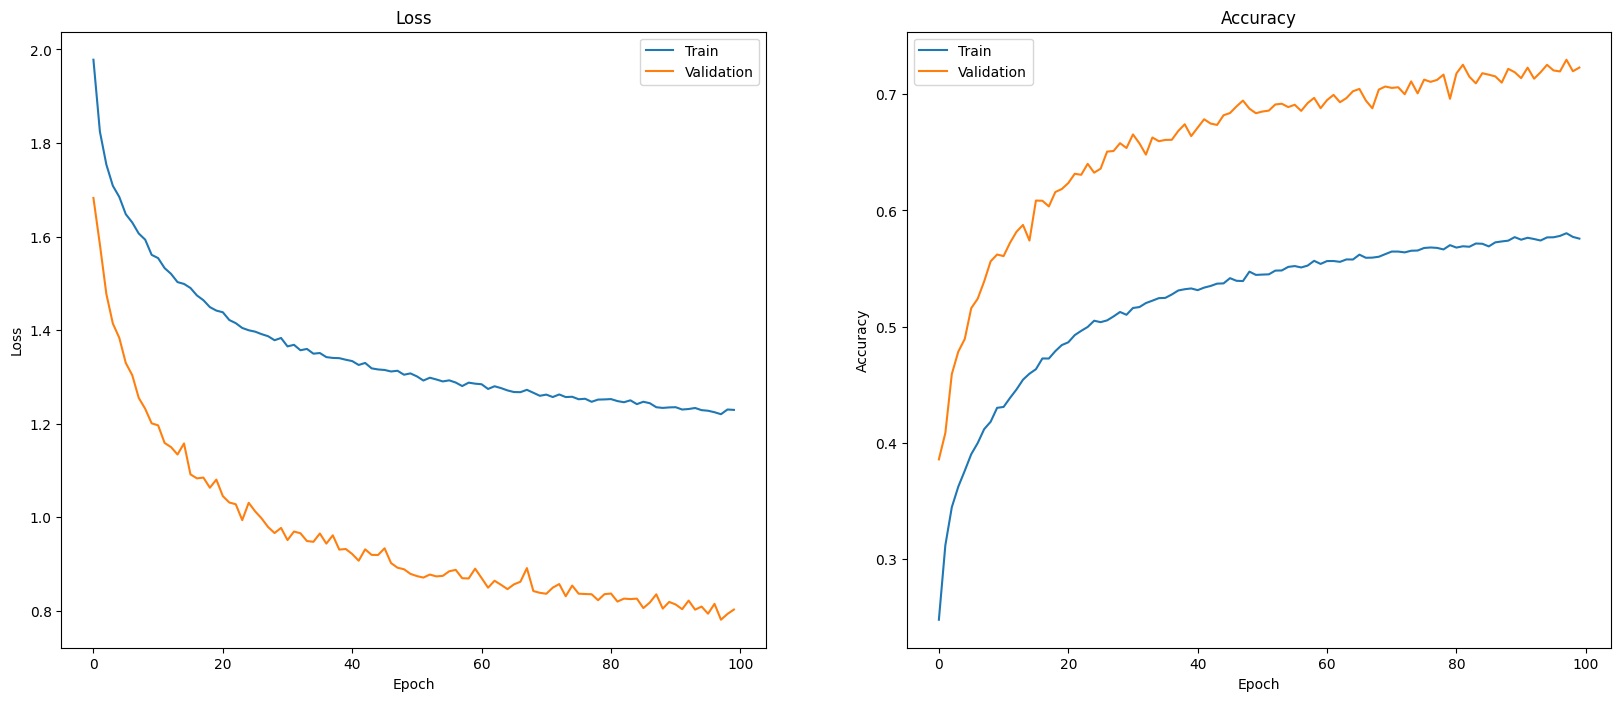

In [52]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

ax1, ax2 = ax.flatten()

ax1.plot(loss_hist['train'], label='Train')
ax1.plot(loss_hist['val'], label='Validation')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

ax2.plot(acc_hist['train'], label='Train')
ax2.plot(acc_hist['val'], label='Validation')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

plt.show()

In [ ]:
net.load_state_dict(torch.load(os.path.join(PATH, 'net.pt')))

<All keys matched successfully>

## Проверка модели на тестовых данных

In [30]:
pred_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / dataset_sizes['test']))

Accuracy on the 10000 test images: 72.66 %


## Использование предобученной модели

In [36]:
from torchvision.models import resnet50, ResNet50_Weights

resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

resnet = resnet.to(device)

print(f'Number of parameters: {sum(p.numel() for p in resnet.parameters())}')

Number of parameters: 23528522


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=0)

In [38]:
resnet, loss_hist_resnet, acc_hist_resnet = train_model(resnet, criterion, optimizer, scheduler)

Epoch 1/25
----------
train Loss: 2.3137 Accuracy: 0.1811
val Loss: 2.1578 Accuracy: 0.2367

Epoch 2/25
----------
train Loss: 1.9197 Accuracy: 0.2734
val Loss: 1.7185 Accuracy: 0.3639

Epoch 3/25
----------
train Loss: 1.6965 Accuracy: 0.3650
val Loss: 1.5592 Accuracy: 0.4130

Epoch 4/25
----------
train Loss: 1.5781 Accuracy: 0.4181
val Loss: 1.4199 Accuracy: 0.4728

Epoch 5/25
----------
train Loss: 1.4914 Accuracy: 0.4518
val Loss: 1.3456 Accuracy: 0.5158

Epoch 6/25
----------
train Loss: 1.4066 Accuracy: 0.4892
val Loss: 1.2987 Accuracy: 0.5211

Epoch 7/25
----------
train Loss: 1.3141 Accuracy: 0.5254
val Loss: 1.2125 Accuracy: 0.5674

Epoch 8/25
----------
train Loss: 1.2224 Accuracy: 0.5633
val Loss: 1.1867 Accuracy: 0.5742

Epoch 9/25
----------
train Loss: 1.1747 Accuracy: 0.5845
val Loss: 1.0543 Accuracy: 0.6281

Epoch 10/25
----------
train Loss: 1.0864 Accuracy: 0.6167
val Loss: 0.9986 Accuracy: 0.6437

Epoch 11/25
----------
train Loss: 1.0346 Accuracy: 0.6339
val Loss: 

In [ ]:
torch.save(resnet.state_dict(), os.path.join(PATH, "resnet.pt"))

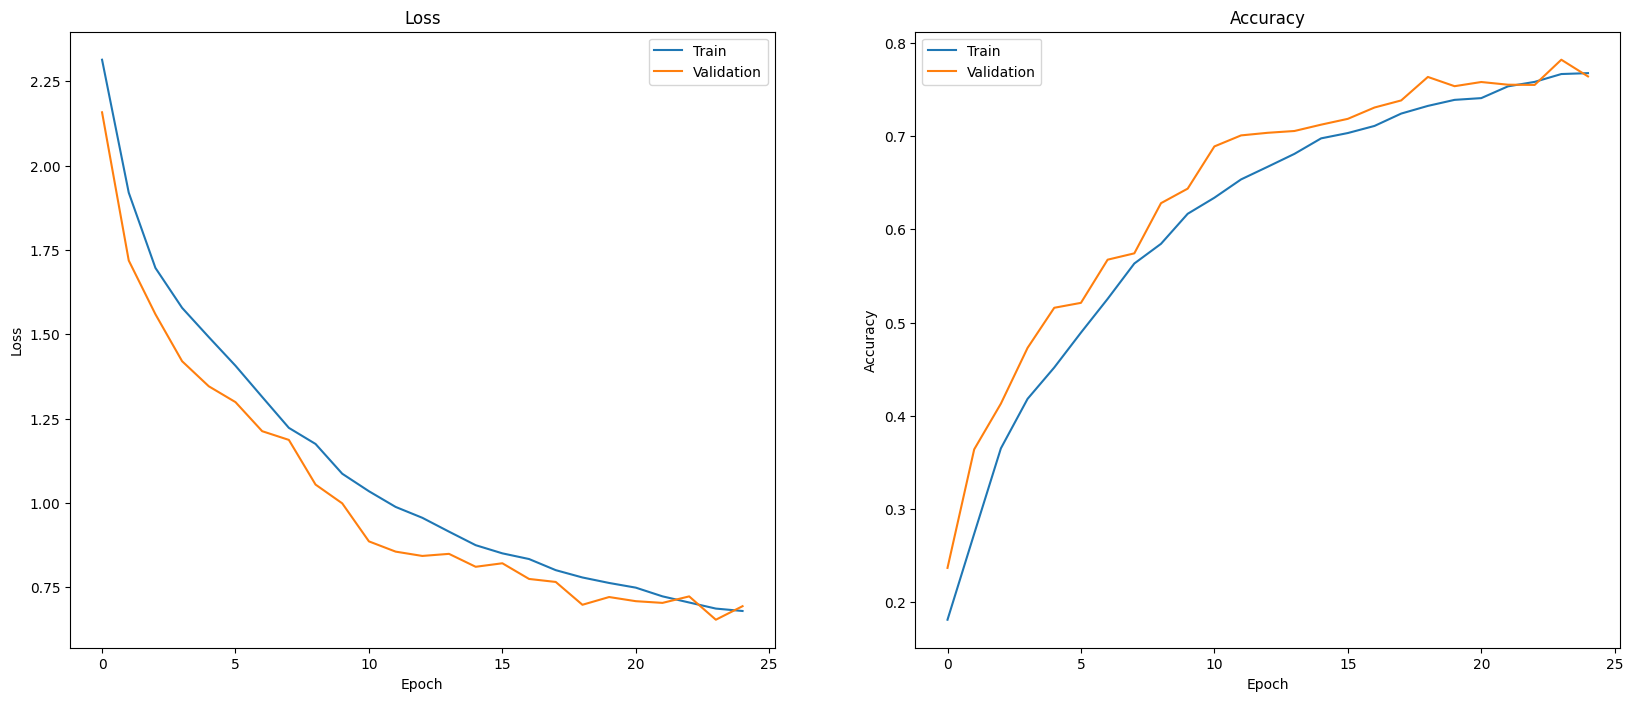

In [56]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

ax1, ax2 = ax.flatten()

ax1.plot(loss_hist_resnet['train'], label='Train')
ax1.plot(loss_hist_resnet['val'], label='Validation')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

ax2.plot(acc_hist_resnet['train'], label='Train')
ax2.plot(acc_hist_resnet['val'], label='Validation')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

plt.show()

In [55]:
resnet.load_state_dict(torch.load(os.path.join(PATH, 'resnet.pt')))

<All keys matched successfully>

In [50]:
pred_vec = []
correct = 0
resnet.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / dataset_sizes['test']))

Accuracy on the 10000 test images: 77.42 %
